In [1]:
# -*- coding: utf-8 -*-
"""
Example script

Script to perform some corrections in the brief audio project

Created on Fri Jan 27 09:08:40 2023

@author: ValBaron10
"""

# Import
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from features_functions import compute_features
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, learning_curve

# Set the paths to the files 
data_path = "Data/"

# Names of the classes
classes_paths = ["Cars/", "Trucks/"]
classes_names = ["car", "truck"]
# cars_list = [4,5,7,9,10,15,20,21,23,26,30,38,39,44,46,48,51,52,53,57]
cars_list = [4,5,7,9,10,15,20,21,23,26,30,38,39,44,46,48,51,52,53,57]
# trucks_list = [2,4,10,11,13,20,22,25,27,30,31,32,33,35,36,39,40,45,47,48]
trucks_list = [2,4,10,11,13,20,22,25,27,30,31,32,33,35,36,39,40,45,47,48]


nbr_of_sigs = 20 # Nbr of sigs in each class
seq_length = 0.2 # Nbr of second of signal for one sequence
nbr_of_obs = int(nbr_of_sigs*10/seq_length) # Each signal is 10 s long

# Go to search for the files
learning_labels = []
for i in range(2*nbr_of_sigs):
    if i < nbr_of_sigs:
        name = f"{classes_names[0]}{cars_list[i]}.wav"
        class_path = classes_paths[0]
    else:
        name = f"{classes_names[1]}{trucks_list[i - nbr_of_sigs]}.wav"
        class_path = classes_paths[1]

    # Read the data and scale them between -1 and 1
    fs, data = sio.wavfile.read(data_path + class_path + name)
    data = data.astype(float)
    data = data/32768

    # Cut the data into sequences (we take off the last bits)
    data_length = data.shape[0]
    nbr_blocks = int((data_length/fs)/seq_length)
    seqs = data[:int(nbr_blocks*seq_length*fs)].reshape((nbr_blocks, int(seq_length*fs)))

    for k_seq, seq in enumerate(seqs):
        # Compute the signal in three domains
        sig_sq = seq**2
        sig_t = seq / np.sqrt(sig_sq.sum())
        sig_f = np.absolute(np.fft.fft(sig_t))
        sig_c = np.absolute(np.fft.fft(sig_f))

        # Compute the features and store them
        features_list = []
        N_feat, features_list = compute_features(sig_t, sig_f[:sig_t.shape[0]//2], sig_c[:sig_t.shape[0]//2], fs)
        features_vector = np.array(features_list)[np.newaxis,:]

        if k_seq == 0 and i == 0:
            learning_features = features_vector
            learning_labels.append(classes_names[0])
        elif i < nbr_of_sigs:
            learning_features = np.vstack((learning_features, features_vector))
            learning_labels.append(classes_names[0])
        else:
            learning_features = np.vstack((learning_features, features_vector))
            learning_labels.append(classes_names[1])

print(learning_features.shape)
print(len(learning_labels))

(1983, 71)
1983


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
n_samples, n_features, n_classes = len(learning_features), 71, 2
indices = np.arange(n_samples)
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(learning_features, learning_labels, indices, test_size=0.2)

In [3]:
# Standardize the labels
labelEncoder = preprocessing.LabelEncoder().fit(y_train)
learningLabelsStd = labelEncoder.transform(y_train)
testLabelsStd = labelEncoder.transform(y_test)

scaler = preprocessing.StandardScaler(with_mean=True).fit(X_train)
learningFeatures_scaled = scaler.transform(X_train)
testFeatures_scaled = scaler.transform(X_test)


In [44]:
# initialization of parameters for RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 11)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']
for x in np.linspace(start = 35, stop = 60, num = 6):
    max_features.append(int(x))

# Criterion
criterion = ['gini', 'entropy', 'log_loss']

# Maximum number of levels in tree
max_depth = [4, 6, 8, 10, 12, 14, 16, 18, 20 ,22 ,23 ,24 ,26 ,28]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
# Learn the model
model = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = model,
                                param_distributions=random_grid,
                                n_iter = 50,
                                cv = 4,
                                verbose=2,
                                random_state=42)
clf_random.fit(learningFeatures_scaled, learningLabelsStd)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=12, max_features=60, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   8.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=12, max_features=60, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   8.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=12, max_features=60, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   9.3s
[CV] END bootstrap=True, criterion=entropy, max_depth=12, max_features=60, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   9.7s
[CV] END bootstrap=True, criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   0.3s
[CV] END bootstrap=True, criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   0.3s
[CV] END bootstrap=True,

[CV] END bootstrap=False, criterion=log_loss, max_depth=12, max_features=40, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   5.7s
[CV] END bootstrap=False, criterion=log_loss, max_depth=12, max_features=40, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   5.6s
[CV] END bootstrap=False, criterion=log_loss, max_depth=16, max_features=60, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  11.1s
[CV] END bootstrap=False, criterion=log_loss, max_depth=16, max_features=60, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  11.8s
[CV] END bootstrap=False, criterion=log_loss, max_depth=16, max_features=60, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  11.8s
[CV] END bootstrap=False, criterion=log_loss, max_depth=16, max_features=60, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=  10.3s
[CV] END bootstrap=False, criterion=log_loss, max_depth=23, max_feat

[CV] END bootstrap=False, criterion=log_loss, max_depth=22, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=False, criterion=log_loss, max_depth=22, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=False, criterion=log_loss, max_depth=22, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=False, criterion=log_loss, max_depth=22, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, criterion=log_loss, max_depth=22, max_features=55, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   5.5s
[CV] END bootstrap=True, criterion=log_loss, max_depth=22, max_features=55, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   6.4s
[CV] END bootstrap=True, criterion=log_loss, max_depth=22, max_features=

[CV] END bootstrap=True, criterion=entropy, max_depth=16, max_features=50, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   7.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=16, max_features=50, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   8.2s
[CV] END bootstrap=False, criterion=gini, max_depth=4, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.8s
[CV] END bootstrap=False, criterion=gini, max_depth=4, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.9s
[CV] END bootstrap=False, criterion=gini, max_depth=4, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.9s
[CV] END bootstrap=False, criterion=gini, max_depth=4, max_features=35, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.9s
[CV] END bootstrap=False, criterion=log_loss, max_depth=22, max_features=50, min_samples_lea

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [4, 6, 8, 10, 12, 14, 16,
                                                      18, 20, 22, 23, 24, 26,
                                                      28, None],
                                        'max_features': ['sqrt', 'log2', 35, 40,
                                                         45, 50, 55, 60],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190, 200]},
                   random_state=42, verbose=2)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       209
           1       0.89      0.96      0.93       182

    accuracy                           0.93       391
   macro avg       0.93      0.93      0.93       391
weighted avg       0.93      0.93      0.93       391



C:\Users\utilisateur\anaconda3\envs\amelioration\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


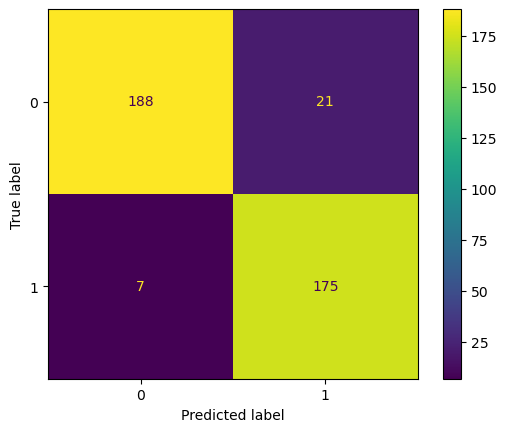

In [49]:
from sklearn.metrics import f1_score
# Prediction
predict = clf_random.best_estimator_.predict(testFeatures_scaled)

# Accuracy 
print(classification_report(testLabelsStd, predict))

# Matrix confusion
plot_confusion_matrix(clf_random.best_estimator_, testFeatures_scaled, testLabelsStd) 
plt.show()

In [48]:
clf_random.best_params_

{'n_estimators': 170,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 22,
 'criterion': 'log_loss',
 'bootstrap': False}

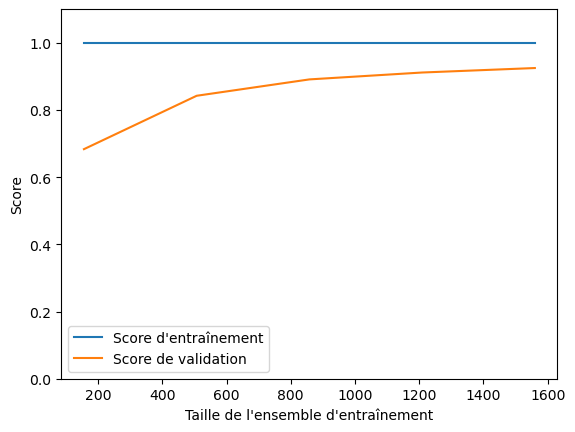

In [51]:
# Calcul de la courbe d'apprentissage

features = np.append(learningFeatures_scaled, testFeatures_scaled, axis = 0)
labels = np.append(learningLabelsStd, testLabelsStd, axis = 0)
train_sizes, train_scores, test_scores = learning_curve(clf_random.best_estimator_, features, labels, cv=5)

# Calcul de la moyenne des scores pour l'ensemble d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Tracé de la courbe d'apprentissage
plt.plot(train_sizes, train_scores_mean, label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, label="Score de validation")

# Ajout des étiquettes et des limites pour les axes
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.legend()
plt.ylim(0, 1.1)

# Afficher la courbe
plt.show()

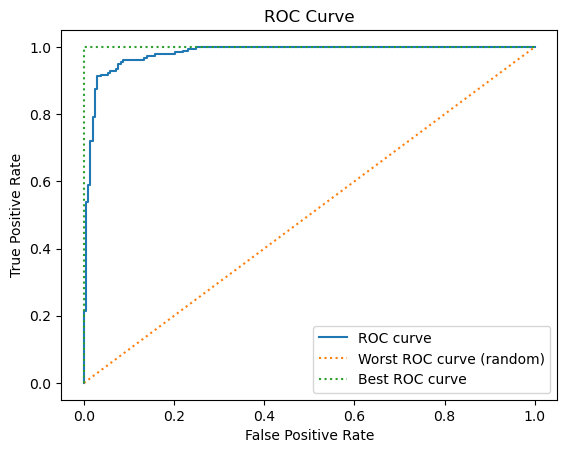

model 1 AUC score: 0.9305299963194701


In [87]:
# Predict probability
predict_proba = clf_random.best_estimator_.predict_proba(testFeatures_scaled)

# Defin metrics
fpr, tpr, thresholds = roc_curve(testLabelsStd, predict_proba[:,1])
worst_x = [0,1]
worst_y = [0,1]
best_x = [0,0,1]
best_y = [0,1,1]

# Plot Metrics
plt.plot(fpr,tpr, label="ROC curve")
plt.plot(worst_x,worst_y, linestyle="dotted", label="Worst ROC curve (random)")
plt.plot(best_x, best_y, linestyle="dotted", label="Best ROC curve")
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

# AUC score
print(f'model 1 AUC score: {roc_auc_score(testLabelsStd, predict)}') 

In [5]:
# Affichage des données mal étiquetées
false_positives = [i for i, (t, p) in enumerate(zip(testLabelsStd, predict)) if t == 0 and p == 1]
false_negatives = [i for i, (t, p) in enumerate(zip(testLabelsStd, predict)) if t == 1 and p == 0]
print("Données mal étiquetées (faux positifs) :", false_positives)
print("Données mal étiquetées (faux négatifs) :", false_negatives)

Données mal étiquetées (faux positifs) : [28, 31, 58, 82, 90, 107, 108, 113, 126, 137, 153, 168, 193, 249, 258, 267, 270, 289, 306, 312, 313, 329]
Données mal étiquetées (faux négatifs) : [6, 25, 38, 181, 219, 322, 333, 344, 379, 386]


In [6]:
error = false_negatives + false_positives

In [7]:
learning_features = np.delete(learning_features, indices_test[error], axis = 0)
learning_labels = np.delete(learning_labels, indices_test[error], axis = 0)

In [8]:
n_samples, n_features, n_classes = len(learning_features), 71, 2
indices = np.arange(n_samples)
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(learning_features, learning_labels, indices, test_size=0.2)

In [9]:
# Standardize the labels
labelEncoder = preprocessing.LabelEncoder().fit(y_train)
learningLabelsStd = labelEncoder.transform(y_train)
testLabelsStd = labelEncoder.transform(y_test)

scaler = preprocessing.StandardScaler(with_mean=True).fit(X_train)
learningFeatures_scaled = scaler.transform(X_train)
testFeatures_scaled = scaler.transform(X_test)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       209
           1       0.89      0.96      0.92       182

    accuracy                           0.93       391
   macro avg       0.93      0.93      0.93       391
weighted avg       0.93      0.93      0.93       391



C:\Users\utilisateur\anaconda3\envs\amelioration\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


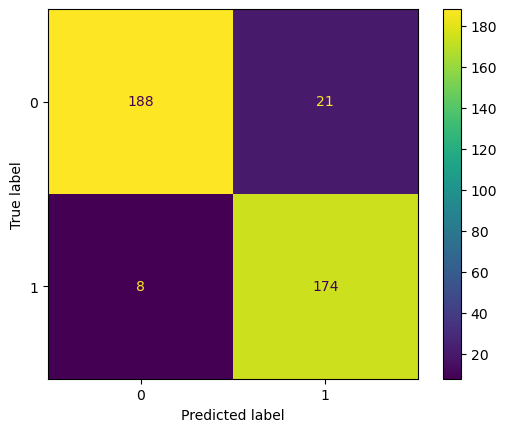

In [10]:
# Learn the model
model = RandomForestClassifier(n_estimators = 120,
                                random_state=42,
                                max_depth = 20,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_features = 47,
                                criterion = 'entropy'
                                )
model.fit(learningFeatures_scaled, learningLabelsStd)

# Predict
predict = model.predict(testFeatures_scaled)

# Accuracy 
print(classification_report(testLabelsStd, predict))

# Matrix confusion
plot_confusion_matrix(model, testFeatures_scaled, testLabelsStd) 
plt.show()